In [70]:
# imPORT LIBRARIES 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import pi, sqrt
import handcalcs.render
import pandas as pd
import json 
# !pip install handcalcs

In [71]:
# CONFIGURATIONS
#help(handcalcs.set_option)
handcalcs.set_option("latex_block_start", "$")
handcalcs.set_option("latex_block_end", "$")
handcalcs.set_option("math_environment_end", "aligned")
handcalcs.set_option("use_scientific_notation",True)

# LLC tank pre-design calculations <a class="title_class" id="title_1"></a>

## Table of contents
* [Voltage Gain – Theoretical Overview](#title_2)
* [Inputs and Specifications](#title_3)
* [Transfo ratio and Voltage Gain](#title_4)
* [Lm, Lr, Cr tank](#title_5)
* [References <a id="referencesID"></a>  ](#title_7)

### Voltage Gain – Theoretical Overview <a class="title_class" id="title_2"></a>

<img src="./02_simulation/Schematic1.png" style="width:19cm;">


<br>

The voltage gain function (normalized) expression is:

$$
M_g = \left| \frac{L_n \cdot f_n^2}{\left[(L_n + 1) \cdot f_n^2 - 1\right] + j\left[(f_n^2 - 1) \cdot f_n \cdot Q_e \cdot L_n\right]} \right|
$$

With:

$$
L_n = \frac{L_m}{L_r}, \quad Q_e = \frac{\sqrt{\frac{L_r}{C_r}}}{R_e}, \quad f_n = \frac{f_{sw}}{f_0}, \quad f_0 = \frac{1}{2\pi\sqrt{L_r C_r}}
$$
See page 3 formula (23) [\[1\]](#referencesID1).
<br> You can found all formula of this chapeter in the same ref 

In [72]:
def calculate_Mg(Ln, fn, Qe):
    numerator = Ln * fn**2
    denominator_real = (Ln + 1) * fn**2 - 1
    denominator_imag = (fn**2 - 1) * fn * Qe * Ln
    denominator = np.sqrt(denominator_real**2+ denominator_imag**2)
    Mg = abs(numerator / denominator)
    return Mg


In [73]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4.5)) 

fn = np.arange(0.1, 10 + 0.01, 0.01)
Qearr = np.array ([0,0.3,0.5,1,2,5,10])


for ax_idx, Ln in enumerate((1,3, 10)):
    ax = axs[ax_idx]
    
    #Qe = np.array([1, 2, 3, 5, 7, 9])
    #Qearr = np.array([0] + list(Qe * 0.1) + list(Qe))
    

    for Qe in Qearr:
        Mg = calculate_Mg(Ln, fn, Qe)
        ax.plot(fn, Mg, label=f"Qe={Qe:.1f}")

    Mg_max = []
    frMg_max = []
    mg0 = None

    for Qe in np.arange(0, 1, 0.01):
        Mg = calculate_Mg(Ln, fn, Qe)
        i = np.argmax(Mg)
        Mg_max.append(Mg[i])
        frMg_max.append(fn[i])
        if mg0 is None:
            mg0 = Mg

    frMg_max = np.array(frMg_max)
    m = frMg_max < 0.95
    frMg_max = frMg_max[m]
    Mg_max = np.array(Mg_max)
    Mg_max = Mg_max[m]

    frMg_max = np.array(frMg_max.tolist() + [1, 1, 10])
    Mg_max = np.array(Mg_max.tolist() + [1, 0, 0])
    ax.plot(frMg_max, Mg_max, c="g", linestyle="--")

    m = fn > frMg_max.min()
    fn2 = fn[m]
    mg0 = mg0[m]

    interp_y2 = interp1d(frMg_max, Mg_max, kind='linear', fill_value='extrapolate')
    Mg_max_interp = interp_y2(fn2)

    ax.fill_between(fn2, mg0, Mg_max_interp, color='lightgreen', alpha=0.5, label='inductance area ZVS')

    #ax.legend()
    #if ax_idx == 2:
    #    ax.legend(loc='lower center', bbox_to_anchor=(1.3, 0.1), ncol=1)
    if ax_idx ==1:
        pass
        # Use figure coordinates for bbox_to_anchor by adding bbox_transform=fig.transFigure
        #ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=8, bbox_transform=fig.transFigure)


    ax.set_xscale("log")
    ax.grid()
    ax.set_xlabel("normal freq : fn")
    ax.set_ylabel("Mg")
    ax.set_ylim([0, 2])
    ax.set_xlim([1e-1, 10])
    ax.set_title(f"Ln = {Ln}")

plt.tight_layout()
fig.suptitle("LLC Voltage Gain (Mg) Across Various Ln and Qe Values, Including the ZVS Zone", 
             x=0.5, y=1.02)



fig.legend(
    handles=axs[1].get_legend_handles_labels()[0],
    labels=axs[1].get_legend_handles_labels()[1],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),  # adjust vertical position
    ncol=8,
    frameon=False
)
plt.savefig(r'.\03_figs\LLC_voltage_gain_Mg.jpg'
            , bbox_inches='tight')

plt.close()


<img src='.\03_figs\LLC_voltage_gain_Mg.jpg' style="width:19cm;">

### Inputs and Specifications <a class="title_class" id="title_3"></a>

In [74]:
%%render
# Input voltage

V_In_min = 360 # v
V_In_nom = 380 # v
V_In_max = 400 # v


# Output Voltage
Vo_min = 46 # v
Vo_nom = 48 # v
Vo_max = 52 # v

# Power
Power = 1200 # w

# Central Frequencey
f_nom = 100e3 # Hz

<IPython.core.display.Latex object>

**Inputs data**

In [75]:
dic_txt = "V_In_min,V_In_nom,V_In_max,Vo_min,Vo_nom,Vo_max,Power,f_nom"

dic_in= {}
for x in dic_txt.split(","): 
    dic_in[x]= round(float(eval(x)), 3)

with open("04_outputs/inp_datas.json","w") as f: 
    json.dump(dic_in,f, indent = 4)
display (dic_in)

{'V_In_min': 360.0,
 'V_In_nom': 380.0,
 'V_In_max': 400.0,
 'Vo_min': 46.0,
 'Vo_nom': 48.0,
 'Vo_max': 52.0,
 'Power': 1200.0,
 'f_nom': 100000.0}

### Transfo ratio and Voltage Gain <a class="title_class" id="title_4"></a>

In [76]:
%%render
n = V_In_nom/(Vo_nom*2)

<IPython.core.display.Latex object>

Choose an integer value to simplify the transformer design.

In [77]:
%%render
n = round(n)

<IPython.core.display.Latex object>

In [99]:
%%render long
Vf=0.2 # drop voltage in the mos
efficiency = 0.95 # hypothesis
loss = 1-efficiency
Io_nom = Power/Vo_nom # A
V_lossAll = ((Power*loss)/efficiency)/Io_nom # v
V_loss= V_lossAll/3 # hypothesis 1/3 of losses are Joule losses

<IPython.core.display.Latex object>

In [100]:
%%render
margin = 0.01
Mg_min = n*(Vo_min*(1-margin)+Vf)/(V_In_max/2)

Mg_max = n*(Vo_max*(1+margin)+Vf+V_loss)/(V_In_min/2)


# 110% load
Mg_max110 = Mg_max*(105/100)


<IPython.core.display.Latex object>

### Lm, Lr, Cr tank <a class="title_class" id="title_5"></a>

In [101]:
def LLC_from_Qe_Ln(Lnc, Qec):

  f=np.arange(0.2,5,0.0001)
  mg = calculate_Mg(Lnc,f, Qec)
  Mg_c= mg.max()




  i = np.abs(mg-Mg_min).argmin()
  i = np.abs(mg-Mg_max110).argmin()
  mg_max_close= mg[i]

  fn_min= f[i]
  #print2(fn_min)


  #mg = calculate_Mg(Lnc,f, Qec)
  mg = calculate_Mg(Lnc,f, 0)
  i = np.abs(mg-Mg_min).argmin()
  fn_max = f[i]
  mg_min_close= mg[i]

  _='''
  mask1= f>fn_min
  mask2= f<fn_max
  mask = mask1 & mask2
  f2 = f[mask]
  mg2 = mg[mask]

  mask1 = mg2>Mg_min
  mask2 = mg2<Mg_max110
  mask = mask1 & mask2
  f2 = f2[mask]
  mg2 = mg2[mask]

  #print2(mg2)
  VmMax= mg2*2*np.sqrt(2)*V_In_max/(pi)
  #print2(V_In_max, VmMax, mg2)
  Ae = 211e-6
  fsw = f2*f_nom
  Bpeak = VmMax/(4.44*fsw*n*Ae)
  # print2(fsw,  n, Ae)
  try:
    Bpeak_max = Bpeak.max()
  except:
    Bpeak_max = np.nan
  #print(Bpeak_max)
  '''






  # 100 load

  Re_nom = 8*n**2*Vo_nom / (pi**2*Io_nom)
  Re_nom = np.round(Re_nom, 3)
  # print2(Re_nom)

  # 110% load

  Re_110 = 8*n**2*Vo_nom / (pi**2*Io_nom*1.1)
  #Re_110 = np.round(Re_110, 1)
  # print2(Re_110)
  P_re_110 = (V_In_nom/2)**2/Re_nom
  #P_re_110 = np.round(P_re_110, 0)
  # print2(P_re_110)



  Cr_nF= 1e9/ (2*pi * Qec* f_nom*Re_nom)




  Cr = Cr_nF
  Cr = np.round(Cr, 3)


  Lr = 1/ ((2*pi * f_nom)**2*Cr*1e-9)
  Lr_uH = Lr *1e6 # uH
  Lr_uH = np.round(Lr_uH, 3)
  #Lr = 60 # choise

  Lm = Lr*Lnc
  #Lm = np.round(Lm, 1)
  Lm_uH = Lm *1e6 # uH
  Lm_uH = np.round(Lm_uH, 3)








  fsw_min = fn_min*f_nom
  fsw_min = np.round(fsw_min, 2)

  fsw_max = fn_max*f_nom
  fsw_max = np.round(fsw_max, 2)




  wmin= 2*pi * fsw_min
  wmax= 2*pi * fsw_max
  #print2(fsw_min, Lm)

  # The RMS magnetizing current (im) at fsw_min
  im = 2*np.sqrt(2)*n*Vo_nom/(pi*Lm*wmin)

  # The primary-side RMS load current (Ioe) with a 110% overload i
  Io= Io_nom
  Ioe= 1.1*pi*Io/(n*2*np.sqrt(2))


  # The resonant circuit’s current (Ir)
  Ir = np.sqrt(im**2+Ioe**2)


  Ae = 211e-6
  le = 114e-3
  ue=188
  u0= 4*pi*1e-7

  Bpeak_max = 1000*(im*u0*ue*n/le)
  Hmax = im*n/le
  return Lm_uH,Lr_uH ,Cr_nF, fn_min, fn_max, fsw_min, fsw_max, Ioe ,  im, Ir, Bpeak_max, Hmax
Lnc, Qec = 3, 0.5
Lm_uH,Lr_uH ,Cr_nF, fn_min, fn_max, fsw_min, fsw_max, Ioe ,  Im_rms, Ir, Bpeak_max, Hmax = LLC_from_Qe_Ln(Lnc, Qec)
#print2(Lm_uH,Lr_uH ,Cr_nF, fn_min, fn_max, fsw_min, fsw_max, Ioe ,  Im_rms, Ir, Bpeak_max, Hmax)

In [102]:
Lnarr = list(np.arange(1,10,0.01))
Qearr = np.arange(0.1,1,0.01)

Below we will use grid search to find the best values for `Ln` and `Qe`.

**The idea:**
- Change `Ln` in the range: start = 1, stop = 10, step = 0.01 (around 100 points)
- Change `Qe` in the range: start = 0.1, stop = 1, step = 0.01 (around 10 points)

We will select the `Ln` and `Qe` values that give an `Mg` value closest to `Mg_max110`.


In [103]:
# CHOSE QE110 automatically
#Lnc, Qec = 2,0.5
freqn =  np.arange(0.15,1.7,0.01)

data =[]
Ln, Qe = Lnc, Qec
for Ln in Lnarr:
  for Qe in Qearr:
    Mg = calculate_Mg(Ln,freqn, Qe)
    Mg_ape = Mg.max()
    data.append( [Ln, Qe, Mg_ape])

data= np.array(data).T
#print(data.shape)

arr = data[2]
i = np.argmin(np.abs(arr-Mg_max110))
Lnc, Qec, Mg_ape = data.T[i]
#Lnc, Qec, Mg_ape, Mg_max110


**Top 6 (Ln, Qe) Combinations Matching `Mg_max110`**
<br> The following 6 values of `Ln` and `Qe` closely match the target voltage gain `Mg_max110`. 
<br> These rows were selected based on the criterion that `Mg_ape` is nearly equal to `Mg_max110`.

In [104]:
%%render
Mg_max110

<IPython.core.display.Latex object>

In [105]:
arr2=[]
arr = data[2]
for i in np.argsort(np.abs(arr-Mg_max110)):
  Lnc, Qec, Mg_ape = data.T[i]
  Lm_uH,Lr_uH ,Cr_nF, fn_min, fn_max, fsw_min, fsw_max, Ioe ,  Im_rms, Ir, Bpeak_max , Hmax = LLC_from_Qe_Ln(Lnc, Qec)

  dic = {
    "Lnc": Lnc,
    "Qec": Qec,
    "Lm_uH": Lm_uH,
    "Lr_uH": Lr_uH,
    "Cr_nF": Cr_nF,
    "fn_min" : fn_min,
    "fn_max": fn_max,
    "fsw_min": fsw_min,
    "fsw_max": fsw_max,
    "Ioe": Ioe,
    "Im_rms": Im_rms,
    "Ir": Ir,
    "Mg_ape": Mg_ape,
    "Bpeak_max_mT":Bpeak_max,
    "Hmax": Hmax}
  if Mg_ape > Mg_max110 and fn_min < fn_max and Lnc>=2 and Lnc < 10 :
    arr2.append(dic)
    if len(arr2) >=6:
      break
dfllcv = pd.DataFrame(arr2)
dfllcv = dfllcv.sort_values("Lnc")  .reset_index(drop = True )
dfllcv
# in https://www.tdk-electronics.tdk.com/download/540066/dbcde584d155cc270f5d5dbf1efec233/pdf-generaldefinitions.pdf
# page 3
_="""
1.2.2 Saturation magnetization BS
The saturation magnetization BS is defined as the maximum flux density attainable in a material (i.e.
for a very high field strength) at a given temperature; above this value BS, it is not possible to further
increase B(H) by further increasing H.
Technically, BS is defined as the flux density at a field strength of H = 1200 A/m. As is confirmed in
the actual magnetization curves in the chapter on “Materials”, the B(H) characteristic above
1200 A/m remains roughly constant (applies to all ferrites with high initial permeability, i.e. where
 1000)."""
_=""" In practice, to be safe, design for a bit less, like keeping
𝐻
H around 800–1000 A/m maximum, to
"""
dfprint = dfllcv.copy()

dfllcv[['Lnc', 'Qec', 'Lm_uH', 'Lr_uH', 'Cr_nF', 'fn_min', 'fn_max', 'fsw_min',
       'fsw_max', "Mg_ape"]]

Lnc   Qec    Lm_uH   Lr_uH       Cr_nF  fn_min  fn_max  fsw_min   fsw_max  \
0  2.56  0.74   75.077  29.327   86.371731  0.6798  1.1459  67980.0  114590.0   
1  3.00  0.66   78.470  26.157   96.841032  0.6507  1.1780  65070.0  117800.0   
2  3.61  0.58   82.980  22.986  110.198415  0.6126  1.2274  61260.0  122740.0   
3  5.70  0.43   97.136  17.041  148.639723  0.5118  1.4600  51180.0  146000.0   
4  5.92  0.42   98.539  16.645  152.178764  0.4964  1.4930  49640.0  149300.0   
5  6.96  0.38  104.816  15.060  168.197581  0.4714  1.6860  47140.0  168600.0   

     Mg_ape  
0  1.249789  
1  1.249810  
2  1.249946  
3  1.249895  
4  1.249816  
5  1.249913

In [106]:
colors = {i/10:f"C{i}" for i in range(10)}
colors["chose"]='C9'


In [107]:
fig, axs = plt.subplots(2,3, figsize=(13, 7))

axs= axs.flatten()
fig.subplots_adjust(wspace=0.3, hspace=0.4)
fnminplot, fnmaxplot =10,0
nmax = 0
for idx in range(len(dfllcv)):
  ax = axs[idx]
  dic = dfllcv.iloc[idx].to_dict()
  Lnc, Qec, Lm_uH, Lr_uH, Cr_nF,fn_min, fn_max,fsw_min, fsw_max, Ioe, Im_rms, Ir, Mg_ape, Bpeak_max , Hmax  = dic.values()




  fn_min,fn_max = fsw_min/f_nom, fsw_max/f_nom
  if fn_min < fnminplot:
    fnminplot = fn_min
  if fn_max > fnmaxplot:
    fnmaxplot = fn_max

  freqn = np.arange(fn_min*0.7,fn_max*1.2,0.01)



  #Mg = calculate_Mg(Lnc,freqn, Qec)
  #print(Qec)
  #print(np.round(Qec, 1))
  Qecarr = np.arange(0,np.round(Qec, 1), 0.1)
  Qecarr = np.append(Qecarr, Qec)
  #print2(Qecarr)
  for Qe in Qecarr:
    lab = f"Qe={Qe:.2f}"
    c = round(Qe,3)
    if Qe == Qec:
        c = "chose"
        lab = f"Qe=chosed"
    nmax = max (nmax, len(Qecarr))
        

    Mg = calculate_Mg(Lnc,freqn, Qe)
    ax.plot(freqn, Mg, label = lab, c= colors [c])

  Qe = Qec
  Mg = calculate_Mg(Lnc,freqn, Qe)
  i= np.argmin (np.abs(Mg -Mg_min))
  fa1 = freqn[i]
  Qe = 0
  Mg = calculate_Mg(Lnc,freqn, Qe)
  i= np.argmin (np.abs(Mg -Mg_max110))
  fa2 = freqn[i]





  #print2(Qecarr)

  #ax.plot(freqn, Mg)
  #Mg_max = Mg.max()
  #print2(Mg_max)
  ax.plot([fn_min*0.8,fn_max*1.2 ], [Mg_max110, Mg_max110],
           label = "Mg_max_110%", linestyle ="--", c="k")
  ax.plot([fn_min*0.8,fn_max*1.2], [Mg_max,Mg_max ],
          label = "Mg_max", linestyle ="--", c="r")
  ax.plot([fn_min*0.8,fn_max*1.2 ], [Mg_min, Mg_min],
          label = "Mg_min", linestyle ="--", c="b")
  ax.plot([fn_min,fn_min ], [Mg_min*0.8, Mg_max110*1.2],
          label = "fn_min", linestyle ="--", c="g")
  ax.plot([fn_max,fn_max ], [Mg_min*0.8, Mg_max110*1.2],
          label = "fn_max", linestyle ="--", c="y")


  ax.plot([fa1,fa1 ], [Mg_min*0.8, Mg_max110*1.2],
          linestyle =":",label="fa1")
  ax.plot([fa2,fa2  ], [Mg_min*0.8, Mg_max110*1.2],
          linestyle =':',label="fa2")





  #ax.legend()
  ax.legend(loc='center', bbox_to_anchor=(1, 0.6), ncol=1)
  # ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3)
  #plt.xscale("log")
  #plt.yscale("log")
  ax.set_title(f" Ln={Lnc:0.2f} Qec={Qec:0.2f}")
  ax.grid()#wich= "both")
  ax.set_xlabel("freq_norm")
  ax.set_ylabel("Mg")
  ax.set_ylim([ Mg_min-0.1/2, Mg_max110+0.1/2])
#for ax in axs:
  ax.set_xlim([fnminplot-0.1, fnmaxplot+0.1])

nmax = 0
target_ax = None

# Find the axis with the most lines
for ax in axs:
    if len(ax.lines) > nmax:
        nmax = len(ax.lines)
        target_ax = ax

# Remove all legends
i=0
for ax in axs:
    if i<3:
        #ax.set_xlabel("")
        pass
    if ax.legend_:
        ax.legend_.remove()
    i=i+1

# Add a single legend with 4 columns at bottom of figure
if target_ax:
    handles, labels = target_ax.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),  # X=50%, Y=below figure
        ncol=7,
        frameon=False
    )








plt.suptitle("Grid search for Ln and Qe to find the best pair of values.")
plt.savefig("./03_figs/chose_Ln_Qe.jpg", bbox_inches='tight')

plt.close()  # without showing 

<img src="./03_figs/chose_Ln_Qe.jpg" style="width:19cm;">


In [108]:
%%render
Lnc=3 
Qec = 0.55 

<IPython.core.display.Latex object>

Lnc = 3 and Qec = 0.55 represent an optimal compromise due to the following:

* **Moderate gain slope (ΔM/Δf):**  
  In the inductive region, the gain rises gradually with frequency, enabling stable control without abrupt sensitivity shifts.
* **Limited frequency span (f_min to f_max):**  
  These parameters restrict the switching frequency range, simplifying component design, controller implementation, and consistent ZVS operation.


In [109]:
dfllcvSub= dfllcv.iloc[1,:].to_frame().T

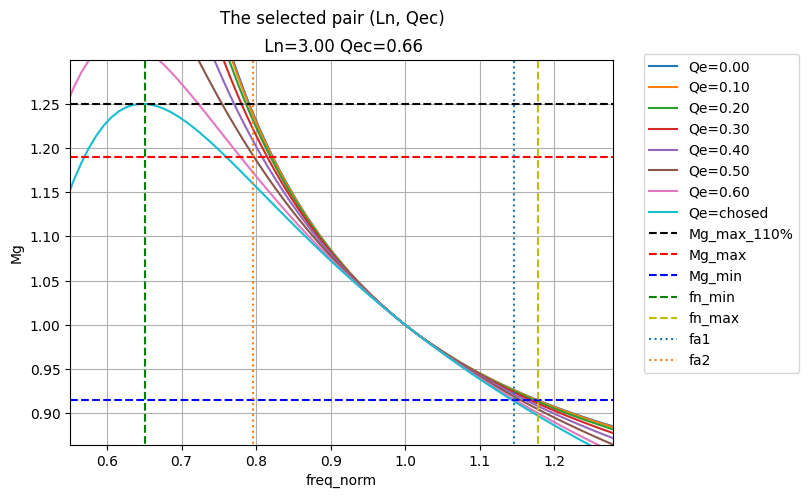

In [110]:
fig, axs = plt.subplots(1,1, figsize=(7, 5))

axs= [axs]
#fig.subplots_adjust(wspace=0.3, hspace=0.4)
fnminplot, fnmaxplot =10,0
nmax = 0
for idx in range(len(dfllcvSub)):
  ax = axs[idx]
  dic = dfllcvSub.iloc[idx].to_dict()
  Lnc, Qec, Lm_uH, Lr_uH, Cr_nF,fn_min, fn_max,fsw_min, fsw_max, Ioe, Im_rms, Ir, Mg_ape, Bpeak_max , Hmax  = dic.values()




  fn_min,fn_max = fsw_min/f_nom, fsw_max/f_nom
  if fn_min < fnminplot:
    fnminplot = fn_min
  if fn_max > fnmaxplot:
    fnmaxplot = fn_max

  freqn = np.arange(fn_min*0.7,fn_max*1.2,0.01)



  #Mg = calculate_Mg(Lnc,freqn, Qec)
  #print(Qec)
  #print(np.round(Qec, 1))
  Qecarr = np.arange(0,np.round(Qec, 1), 0.1)
  Qecarr = np.append(Qecarr, Qec)
  #print2(Qecarr)
  for Qe in Qecarr:
    lab = f"Qe={Qe:.2f}"
    c = round(Qe,3)
    if Qe == Qec:
        c = "chose"
        lab = f"Qe=chosed"
    nmax = max (nmax, len(Qecarr))
        

    Mg = calculate_Mg(Lnc,freqn, Qe)
    ax.plot(freqn, Mg, label = lab, c= colors [c])

  Qe = Qec
  Mg = calculate_Mg(Lnc,freqn, Qe)
  i= np.argmin (np.abs(Mg -Mg_min))
  fa1 = freqn[i]
  Qe = 0
  Mg = calculate_Mg(Lnc,freqn, Qe)
  i= np.argmin (np.abs(Mg -Mg_max110))
  fa2 = freqn[i]





  #print2(Qecarr)

  #ax.plot(freqn, Mg)
  #Mg_max = Mg.max()
  #print2(Mg_max)
  ax.plot([fn_min*0.8,fn_max*1.2 ], [Mg_max110, Mg_max110],
           label = "Mg_max_110%", linestyle ="--", c="k")
  ax.plot([fn_min*0.8,fn_max*1.2], [Mg_max,Mg_max ],
          label = "Mg_max", linestyle ="--", c="r")
  ax.plot([fn_min*0.8,fn_max*1.2 ], [Mg_min, Mg_min],
          label = "Mg_min", linestyle ="--", c="b")
  ax.plot([fn_min,fn_min ], [Mg_min*0.8, Mg_max110*1.2],
          label = "fn_min", linestyle ="--", c="g")
  ax.plot([fn_max,fn_max ], [Mg_min*0.8, Mg_max110*1.2],
          label = "fn_max", linestyle ="--", c="y")


  ax.plot([fa1,fa1 ], [Mg_min*0.8, Mg_max110*1.2],
          linestyle =":",label="fa1")
  ax.plot([fa2,fa2  ], [Mg_min*0.8, Mg_max110*1.2],
          linestyle =':',label="fa2")





  #ax.legend()
  ax.legend(loc='center', bbox_to_anchor=(1.2, 0.6), ncol=1)
  # ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3)
  #plt.xscale("log")
  #plt.yscale("log")
  ax.set_title(f" Ln={Lnc:0.2f} Qec={Qec:0.2f}")
  ax.grid()#wich= "both")
  ax.set_xlabel("freq_norm")
  ax.set_ylabel("Mg")
  ax.set_ylim([ Mg_min-0.1/2, Mg_max110+0.1/2])
#for ax in axs:
  ax.set_xlim([fnminplot-0.1, fnmaxplot+0.1])

nmax = 0
target_ax = None

# Find the axis with the most lines
for ax in axs:
    if len(ax.lines) > nmax:
        nmax = len(ax.lines)
        target_ax = ax











plt.suptitle("The selected pair (Ln, Qec)")
#plt.savefig("./03_figs/chose_Ln_Qe.jpg", bbox_inches='tight')

plt.show()  # without showing 

##  <a class="title_class" id="title_6"></a>

In [111]:
f=np.arange(0.2,5,0.0001)
mg = calculate_Mg(Lnc,f, Qec)
Mg_c= mg.max()




i = np.abs(mg-Mg_min).argmin()
i = np.abs(mg-Mg_max110).argmin()
mg_max_close= mg[i]

fn_min= f[i]
#print2(fn_min)


#mg = calculate_Mg(Lnc,f, Qec)
mg = calculate_Mg(Lnc,f, 0)
i = np.abs(mg-Mg_min).argmin()
fn_max = f[i]
mg_min_close= mg[i]

#### Equivalent resistor

In [112]:
%%render
# 100 load

Re_nom = 8*n**2*Vo_nom / (pi**2*Io_nom)
Re_nom = round(Re_nom,3 )
# print2(Re_nom)

# 110% load

Re_110 = 8*n**2*Vo_nom / (pi**2*Io_nom*1.1)
#Re_110 = np.round(Re_110, 1)
# print2(Re_110)
P_re_110 = (V_In_nom/2)**2/Re_nom
#P_re_110 = np.round(P_re_110, 0)
# print2(P_re_110)

<IPython.core.display.Latex object>

#### Lm, Lr, Cr values

In [113]:
%%render
Cr_nF= 1e9/ (2*pi * Qec* f_nom*Re_nom) # nF




Cr = Cr_nF
Cr = round(Cr, 3)


Lr = 1/ ((2*pi * f_nom)**2*Cr*1e-9)
Lr_uH = Lr *1e6 # uH
Lr_uH = round(Lr_uH, 3)
#Lr = 60 # choise

Lm = Lr*Lnc
#Lm = np.round(Lm, 1)
Lm_uH = Lm *1e6 # uH
#Lm_uH = round(Lm_uH, 1)

<IPython.core.display.Latex object>

**Verification**

In [114]:
%%render
Qcal = sqrt(Lr/(Cr*1e-9))/(Re_110*1.1)
Qec

<IPython.core.display.Latex object>

#### Fsw limites and primary secondary currents 

In [115]:
%%render

fsw_min = round(fn_min*f_nom, 2) # Hz


fsw_max = round(fn_max*f_nom, 2) # Hz




wmin= 2*pi * fsw_min # rad/s
wmax= 2*pi * fsw_max # rad/s
#print2(fsw_min, Lm)

# The RMS magnetizing current (Im_rms) at fsw_min
Im_rms = 2*sqrt(2)*n*Vo_nom/(pi*Lm*wmin) # Arms

# The prIm_rmsary-side RMS load current (Ioe) with a 110% overload i
Io= Io_nom # Arms
Ioe_rms= 1.1*pi*Io/(n*2*sqrt(2)) # Arms @ 110%
Ios_rms= Ioe_rms*n # Arms


# The resonant circuit’s current (Ir)
Ir_rms = sqrt(Im_rms**2+Ioe**2) # Arms

#I_second_rms= Im_rms*n # Arms
L_second_uH  =Lm_uH/n**2 # uH

<IPython.core.display.Latex object>

**Output data**

In [116]:
## Save output data 
out_txt = """Lnc,Qec,Cr_nF,n,Lr_uH,Lm_uH,fsw_min,fsw_max,Im_rms,Io,Ioe_rms,Ios_rms,Ir_rms,L_second_uH,Re_nom,Re_110"""
dic_out= {}
for x in out_txt.split(","): 
    dic_out[x]= round(float(eval(x)), 3)

dic_out['Cr']= dic_out['Cr_nF']*1e-9
dic_out['Lr']= dic_out['Lr_uH']*1e-6
dic_out['Lm']= dic_out['Lm_uH']*1e-6


# prepare file params for ltspice 
with open("02_simulation/02_Test_Lm_Lr_Cr/params.txt","w") as f: 
    params = []
    for k,v in dic_out.items(): 
        params.append(f".param {k}={v}")
    params = "\n".join(params)
    f.write(params)
    

# save json 
with open("04_outputs/out_results.json","w") as f: 
    json.dump(dic_out,f, indent = 4)
# display (dic_out)

S= pd.Series(dic_out, name = "Output datas").to_frame()
display(S)

Output datas
Lnc          3.000000e+00
Qec          6.600000e-01
Cr_nF        9.684100e+01
n            4.000000e+00
Lr_uH        2.615700e+01
Lm_uH        7.847000e+01
fsw_min      6.507000e+04
fsw_max      1.178000e+05
Im_rms       5.388000e+00
Io           2.500000e+01
Ioe_rms      7.636000e+00
Ios_rms      3.054500e+01
Ir_rms       9.346000e+00
L_second_uH  4.904000e+00
Re_nom       2.490100e+01
Re_110       2.263700e+01
Cr           9.684100e-08
Lr           2.615700e-05
Lm           7.847000e-05

## References <a class="title_class" id="title_7"></a>

<a id="referencesID1"></a> [1] Hong Huang, *Designing an LLC Resonant
Half-Bridge Power Converter*. Available: [https://bbs.dianyuan.com/upload/community/2013/12/01/1385867010-65563.pdf](https://bbs.dianyuan.com/upload/community/2013/12/01/1385867010-65563.pdf)
[2] <br>
Code [Python notebook used to make this PDF](./01_LLC_48v_LLC_tank_design_note_v2.ipynb)